In [56]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2

[MRI Scans Alzeimer Detection Dataset (via Hugging Face)](https://huggingface.co/datasets/yogitamakkar178/mri_scans_alzeimer_detection)

In [57]:
from datasets import load_dataset, concatenate_datasets
from transformers import set_seed

set_seed(42)

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("yogitamakkar178/mri_scans_alzeimer_detection")

Resolving data files:   0%|          | 0/9552 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1279 [00:00<?, ?it/s]

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_transform = v2.Compose([
    v2.ToImage(),
    # v2.ColorJitter(brightness=(0.9,1.1), contrast=(0.9,1.1)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5])
])
test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), 
    v2.Normalize(mean=[0.5], std=[0.5])
])

def train_preprocess(data):
    data["image"] = [train_transform(image) for image in data["image"]]
    return data

def test_preprocess(data):
    data["image"] = [test_transform(image) for image in data["image"]]
    return data
    
ds = ds.with_format("torch") # ds = ds.with_format("torch", device=device)

ds = concatenate_datasets([ds["train"], ds["test"]]).shuffle(seed=42)
ds = ds.train_test_split(train_size=0.8, stratify_by_column="label", seed=42)

ds["train"] = ds["train"].with_transform(train_preprocess)
ds["test"] = ds["test"].with_transform(test_preprocess)

In [59]:
train_loader = DataLoader(ds["train"], shuffle=True, batch_size=32)
test_loader = DataLoader(ds["test"], shuffle=True, batch_size=32)

In [60]:
class AlzeimersCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # 1x(128x128) -> 32x(128x128)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)# 32x(128x128) -> 32x(64x64)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 32x(64x64) -> 64x(64x64)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64x(64x64) -> 64x(32x32)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 64x(32x32) -> 128x(32x32)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 128x(32x32) -> 128x(16x16)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 128x(16x16) -> 256x(16x16)
        self.relu4 = nn.LeakyReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 256x(16x16) -> 256x(8x8)

        self.fc1   = nn.Linear(256 * 8 * 8, 256 * 8)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2   = nn.Linear(256 * 8, 4)

    def forward(self, x):
        # first pass
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # second pass
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # third pass
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # fourth pass
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        # flatten
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        
        return x

In [61]:
model = AlzeimersCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [62]:
def train_model(model, optimizer, criterion, device, train_loader, epoch):
    model.train()
    for idx, batch in enumerate(train_loader):
        image = batch["image"].to(device)
        target = batch["label"].to(device)
        outputs = model(image)
        loss = criterion(outputs, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 25 == 0:
            print(f"Epoch [{epoch}].[{idx}] Loss: {loss}")

    with torch.no_grad():
        num_correct = 0
        num_total = 0
        for batch in train_loader:
            image = batch["image"].to(device)
            target = batch["label"].to(device)
            outputs = model(image)
            output = outputs.argmax(dim=1)
            num_correct += (output == target).sum().item()
            num_total += target.size(0)
    accuracy = num_correct / num_total
    print("")
    print(f"Epoch [{epoch}] Train accuracy: {accuracy}")

    return accuracy

def test_model(model, device, test_loader, epoch):
    with torch.no_grad():
        num_correct = 0
        num_total = 0
        for batch in test_loader:
            image = batch["image"].to(device)
            target = batch["label"].to(device)
            outputs = model(image)
            output = outputs.argmax(dim=1)
            num_correct += (output == target).sum().item()
            num_total += target.size(0)
        accuracy = num_correct / num_total
        print("")
        print(f"Epoch [{epoch}] Test accuracy: {accuracy}")
        print("")
        
        return accuracy

In [63]:
num_epochs = 30 # hyperparameter

epochs = list()
train_accuracies = list()
test_accuracies = list()

for epoch in range(1, num_epochs + 1):
    train_accuracy = train_model(model, optimizer, criterion, device, train_loader, epoch)
    test_accuracy = test_model(model, device, test_loader, epoch)

    epochs.append(epoch)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Epoch [1].[0] Loss: 1.3906596899032593
Epoch [1].[25] Loss: 1.2894846200942993
Epoch [1].[50] Loss: 1.2915493249893188
Epoch [1].[75] Loss: 1.1195158958435059
Epoch [1].[100] Loss: 0.8654732704162598
Epoch [1].[125] Loss: 0.8954405188560486
Epoch [1].[150] Loss: 0.7514553666114807
Epoch [1].[175] Loss: 0.6594821214675903
Epoch [1].[200] Loss: 0.4550255835056305
Epoch [1].[225] Loss: 0.5795958042144775
Epoch [1].[250] Loss: 0.5341761112213135

Epoch [1] Train accuracy: 0.7801246537396122

Epoch [1] Test accuracy: 0.7715736040609137

Epoch [2].[0] Loss: 0.6273089051246643
Epoch [2].[25] Loss: 0.2840707004070282
Epoch [2].[50] Loss: 0.46896880865097046
Epoch [2].[75] Loss: 0.7914606928825378
Epoch [2].[100] Loss: 0.524677038192749
Epoch [2].[125] Loss: 0.3976527154445648
Epoch [2].[150] Loss: 0.38947010040283203
Epoch [2].[175] Loss: 0.49833300709724426
Epoch [2].[200] Loss: 0.43419137597084045
Epoch [2].[225] Loss: 0.5038933753967285
Epoch [2].[250] Loss: 0.22195783257484436

Epoch [2] T

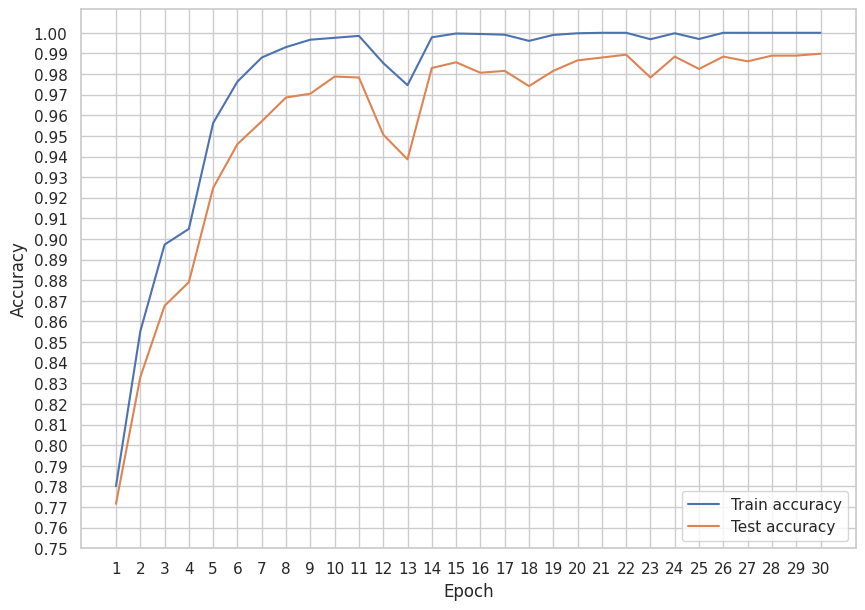

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

accuracies = pd.DataFrame({
    "epoch": epochs, 
    "train": train_accuracies, 
    "test": test_accuracies
})

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 7))
ax = sns.lineplot(accuracies, x=accuracies["epoch"], y=accuracies["train"], label="Train accuracy");
sns.lineplot(accuracies, x=accuracies["epoch"], y=accuracies["test"], label="Test accuracy");
ax.set_xticks(np.arange(1,31,1))
ax.set_yticks(np.arange(0.75,1.01,0.01))
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
plt.legend();

# Reflection
### Results
The best test accuracy was about 99%. The train and test accuracies through the training processes were comparable, with test accuracy trailing behind by about 2% of the train accuracy.

### Changes Made
The accuracy of the model improved drastically after generating my own train-test splits. In the previous model, the train-test splits used were taken directly from the original dataset on Hugging Face. The dataset's original splits were generally unbalanced, which caused the training process to not generalize well enough and overfit to the train set. By merging the original splits and generating my own, I was able to improve the training process and the model's performance as a whole. The test accuracy increased by 10%, and the train and test accuracies were much closer after each epoch.

Data Augmentation was added to the training set in an attempt to generalize the model more to be used against real data. The model did not have any significant improvements in performance, and in fact performed slightly worse, although negligibly. Since it did not improve the model, I decided to remove it keeping in mind that with a larger dataset, it could be more impactful.

### Improvements Needed
Implementing proper normalization in the data transformation pipeline could have helped the neural network, specifically the optimization algorithm. Normalization is added, but it uses generic means and standard deviations considering the range of the brightness of each pixel. Finding the true mean and standard deviation could slightly improve the overall performance of the model.

A better dataset could also have yielded better results. The [dataset](https://huggingface.co/datasets/yogitamakkar178/mri_scans_alzeimer_detection) used is relatively small (~10.8k entries).

Finally, more experimentation is needed with the hyperparameters and other considerations of the model to determine optimal values for each. These include:
- batch size
- learning rate
- number of epochs
- number of hidden layers
- number of filters for each convolutional layer
- type of activation functions used